In [1]:
import sys
sys.path.append('../')
sys.path.append('../code')
import graph_metrics2 as gm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats
from scipy import optimize
import entropy_estimators as ee

import warnings
warnings.filterwarnings("ignore")

import fit

In [2]:
df = pd.read_csv("../../data/topsecret/data251019_ret_diarios.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

VIX = pd.read_csv("../../data/bonus/^VIX_VIX_US_NA.csv")
VIX["Date"] = pd.to_datetime(VIX["Date"])
VIX.set_index("Date", inplace=True)
VIX = VIX["Close"].reindex(index=df.index)

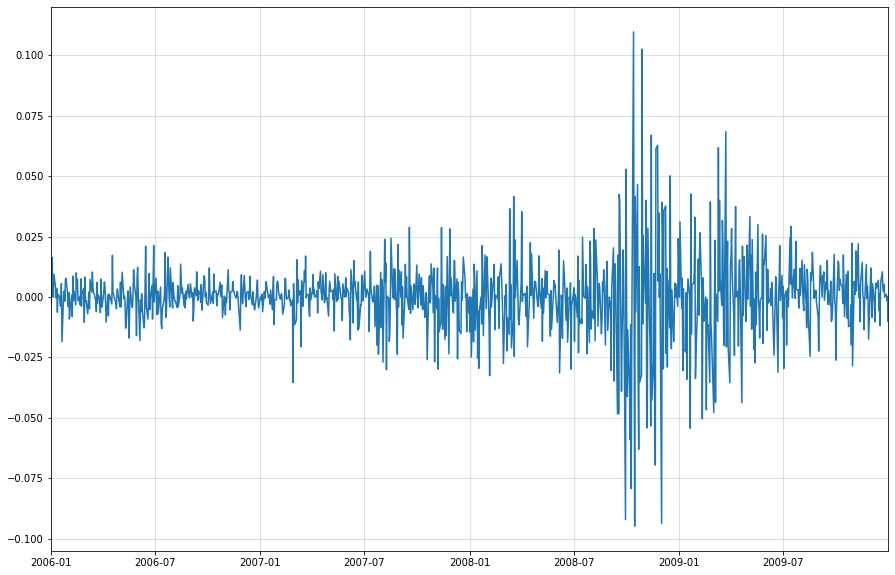

In [34]:
plt.figure(figsize=(15,10))
# plt.ylim(-0.25, 1)
plt.plot(df["SPX"])
# plt.twinx()
# plt.plot(VIX)
# plt.ylim(-30, 90)
plt.grid(alpha=0.5)
plt.xlim("2008", "2008")
plt.show()

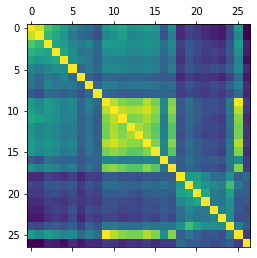

In [4]:
plt.matshow(df.corr())

In [7]:
def MI(s1, s2):
    l = len(s1)
    v1 = s1.reshape(l, 1)
    v2 = s2.reshape(l, 1)
    return ee.mi(v1, v2)

In [31]:
# MI(np.zeros(10), np.ones(10))

-0.06297478353086787

In [34]:
df["2008-09":"2008"].groupby(pd.Grouper(freq="M")).corr(method=MI).max()

SPX         1.796501
CCMP        1.796501
SPTSX       1.191915
MEXBOL      1.167330
IBOV        1.188286
IPSA        1.000000
MERVAL      1.000000
SPBLPGPT    1.137612
IGBC        1.000000
UKX         2.401692
CAC         1.624117
DAX         1.566185
IBEX        1.500954
FTSEMIB     1.527758
AEX         1.529345
OMX         1.431419
RTSI        1.000000
SMI         1.554714
NKY         1.019039
HSI         1.460524
KOSPI       1.019039
TWSE        1.000000
JCI         1.000000
FBMKLCI     1.000000
STI         1.460524
ASX         2.401692
NZSE        1.000000
dtype: float64

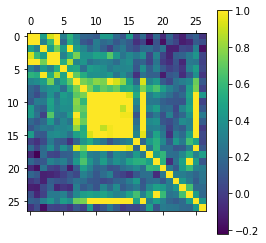

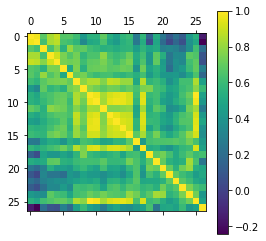

In [32]:
plt.matshow(df["2008-09":"2008-10"].corr(method=MI), vmax=1)
plt.colorbar()
plt.matshow(df["2008-09":"2008-10"].corr())
plt.colorbar()

In [23]:
# dft = pd.DataFrame({v:np.random.normal(size=100) for v in range(15)})
# plt.matshow(dft.corr(method=MI))
# plt.colorbar()
# plt.matshow(dft.corr())
# plt.colorbar()

In [5]:
def mutual_information_series(se1, se2):
    l = len(se1)
    s1 = se1.to_numpy().reshape(l, 1)
    s2 = se2.to_numpy().reshape(l, 1)
    return ee.mi(s1, s2)

In [6]:
times = [
    ("2008-05", "2008-06", "precrisis"),
    ("2008-11", "2008-12", "crisis"),
    ("2013-07", "2013-08", "postcrisis"),
]

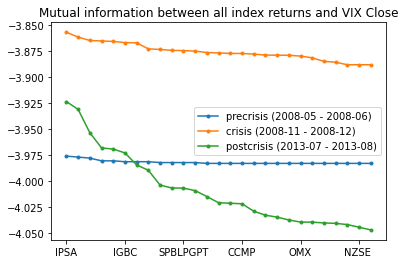

In [7]:
plt.title("Mutual information between all index returns and VIX Close")
for start, end, period in times:
    df[start:end].apply(
        lambda col: mututal_information_series(col, VIX[start:end])
    ).sort_values(ascending=False).plot(style=".-", label=f"{period} ({start} - {end})")
plt.legend()
plt.show()

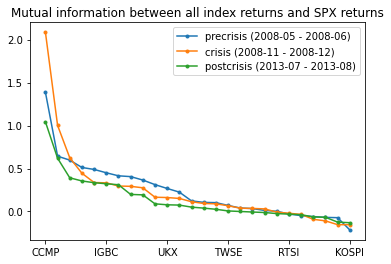

In [8]:
plt.title("Mutual information between all index returns and SPX returns")
for start, end, period in times:
    f = [col for col in df.columns if col not in ["SPX"]]
    df[start:end][f].apply(
        lambda col: mututal_information_series(col, df[start:end]["SPX"])
    ).sort_values(ascending=False).plot(style=".-", label=f"{period} ({start} - {end})")
plt.legend()
plt.show()

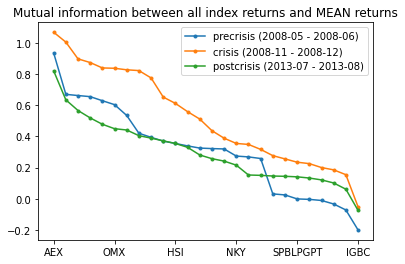

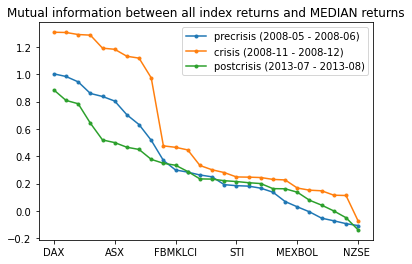

In [9]:
plt.title("Mutual information between all index returns and MEAN returns")
for start, end, period in times:
    df[start:end][f].apply(
        lambda col: mututal_information_series(col, df[start:end].mean(axis=1))
    ).sort_values(ascending=False).plot(style=".-", label=f"{period} ({start} - {end})")
plt.legend()
plt.show()

plt.title("Mutual information between all index returns and MEDIAN returns")
for start, end, period in times:
    df[start:end][f].apply(
        lambda col: mututal_information_series(col, df[start:end].median(axis=1))
    ).sort_values(ascending=False).plot(style=".-", label=f"{period} ({start} - {end})")
plt.legend()
plt.show()

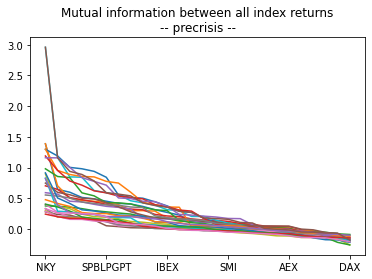

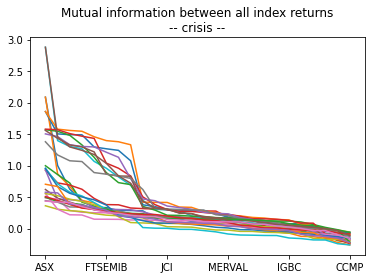

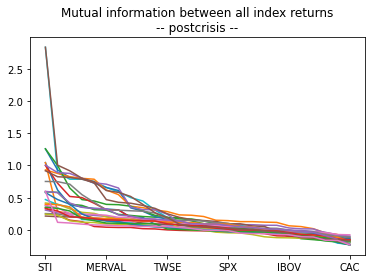

In [10]:
for start, end, period in times:
    plt.title(f"Mutual information between all index returns\n-- {period} --")
    for idx in df.columns:
        f = [col for col in df.columns if col not in [idx]]
        df[start:end][f].apply(
            lambda col: mututal_information_series(col, df[start:end][idx])
        ).sort_values(ascending=False).plot(style="-", label=f"{period} ({start} - {end})")
    plt.show()

In [11]:
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

In [12]:
def compute_IDL(df, plot=True):
    l, w = df.shape
    IDL_list = []
    
    for i,idx1 in enumerate(df):
        mutual_info_list = []
        for j,idx2 in enumerate(df):
            if idx1 == idx2: continue
            s1 = df[idx1].to_numpy().reshape(l, 1)
            s2 = df[idx2].to_numpy().reshape(l, 1)
            mutual_info_list.append(ee.mi(s1, s2))

        y = sorted(mutual_info_list)[::-1]
        x = np.arange(len(y))

        slope = (np.max(y) - np.min(y)) / len(y)
        intercept = np.max(y)
        sol = np.max(y)/(2*slope)

        try:
            popt, pcov = scipy.optimize.curve_fit(exp_decay, x, y, maxfev=2500)
            hl = ((np.log(0.5)-popt[2])/-popt[1])
            if abs(hl) < w:
                IDL = abs(hl)
            else:
                raise ValueError("fitted half life was larger than total number of indices")
        except Exception as e:
            if plot: print(f"[ERROR] {e}")
            IDL = min(abs(sol), w)  # if even sol fails we use max length
            # This is potentially problematic

        IDL_list.append(IDL)

        # visualisation
        if plot:
            plt.title(idx1)
            plt.plot(x, y, ".-", alpha=0.5, label="mi sorted")
            if (IDL == sol) or (IDL == w):
                ymin, ymax = plt.gca().get_ylim()
                plt.plot(x, x*(-slope)+intercept, "--", label="linear fit", color="C2")
                plt.vlines(x=IDL, ymax=ymax, ymin=ymin, linestyle="--", color="blue", label="linear IDL")
            else:
                ymin, ymax = plt.gca().get_ylim()
                plt.plot(x, exp_decay(x, *popt), "-", label="exp decay fit", color="C1")
                plt.vlines(x=IDL, ymax=ymax, ymin=ymin, linestyle="--", color="red", label="exp decay IDL")
            plt.legend()
            plt.show()
            
    return pd.Series(index=df.columns, data=IDL_list)

In [13]:
def compute_IDL2(df, using="SPX",plot=True):
    l, w = df.shape

    if using == "VIX":
        s1 = VIX.reindex(index=df.index).to_numpy().reshape(l, 1)
    elif using == "median":
        s1 = df.median(axis=1).to_numpy().reshape(l, 1)
    elif using == "mean":
        s1 = df.mean(axis=1).to_numpy().reshape(l, 1)
    else:
        s1 = df[using].to_numpy().reshape(l, 1)
    
    mutual_info_list = []

    for j,idx2 in enumerate(df):
        s2 = df[idx2].to_numpy().reshape(l, 1)
        mutual_info_list.append(ee.mi(s1, s2))

    y = sorted(mutual_info_list)[::-1]
    x = np.arange(len(y))

    slope = (np.max(y) - np.min(y)) / len(y)
    intercept = np.max(y)
    sol = np.max(y)/(2*slope)

    try:
        popt, pcov = scipy.optimize.curve_fit(exp_decay, x, y, maxfev=2500)
        hl = ((np.log(0.5)-popt[2])/-popt[1])
        if abs(hl) < w:
            IDL = abs(hl)
        else:
            raise ValueError("fitted half life was larger than total number of indices")
    except Exception as e:
        if plot: print(f"[ERROR] {e}")
        IDL = min(abs(sol), w)  # if even sol fails we use max length
        # This is potentially problematic

    # visualisation
    if plot:
        plt.title(f"{using}  {df.index[0].year}/{df.index[0].month}-{df.index[-1].year}/{df.index[-1].month}")
        plt.plot(x, y, ".-", alpha=0.5, label="mi sorted")
        if (IDL == sol) or (IDL == w):
            ymin, ymax = plt.gca().get_ylim()
            plt.plot(x, x*(-slope)+intercept, "--", label="linear fit", color="C2")
            plt.vlines(x=IDL, ymax=ymax, ymin=ymin, linestyle="--", color="blue", label="linear IDL")
        else:
            ymin, ymax = plt.gca().get_ylim()
            plt.plot(x, exp_decay(x, *popt), "-", label="exp decay fit", color="C1")
            plt.vlines(x=IDL, ymax=ymax, ymin=ymin, linestyle="--", color="red", label="exp decay IDL")
        plt.legend()
        plt.show()
            
    return pd.Series(index=[using], data=IDL)

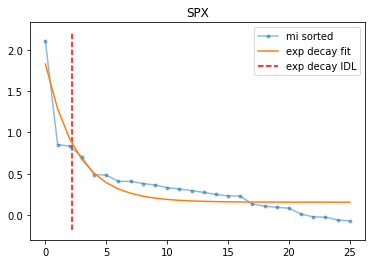

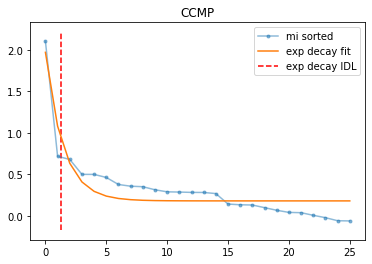

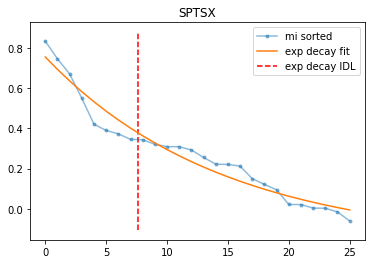

[ERROR] fitted half life was larger than total number of indices


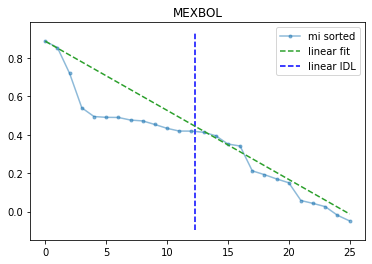

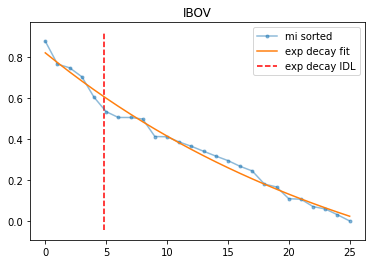

[ERROR] fitted half life was larger than total number of indices


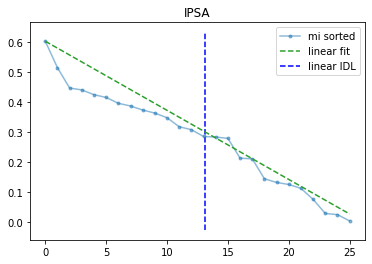

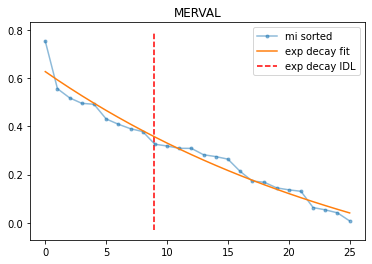

[ERROR] fitted half life was larger than total number of indices


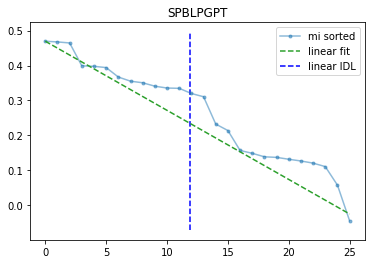

[ERROR] fitted half life was larger than total number of indices


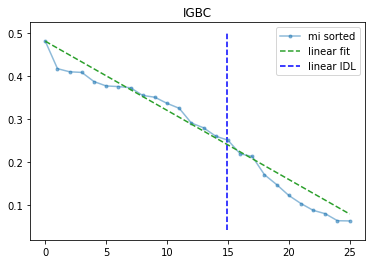

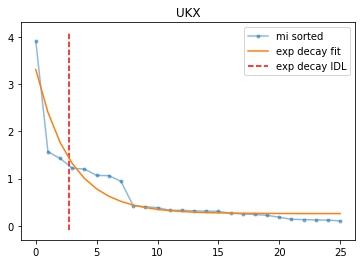

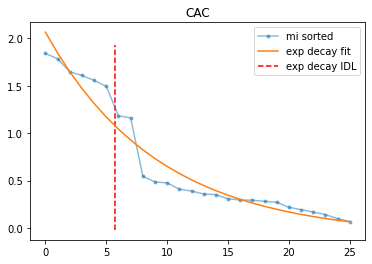

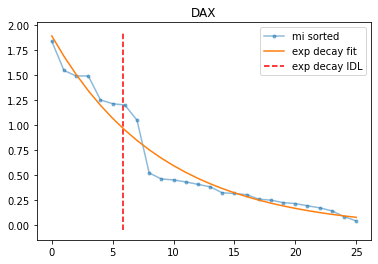

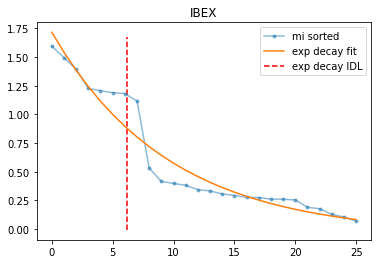

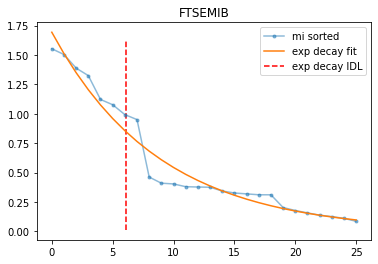

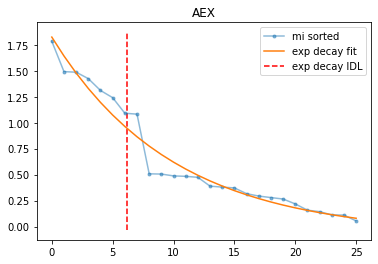

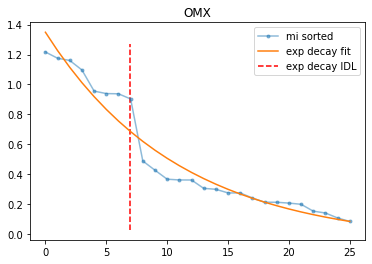

[ERROR] fitted half life was larger than total number of indices


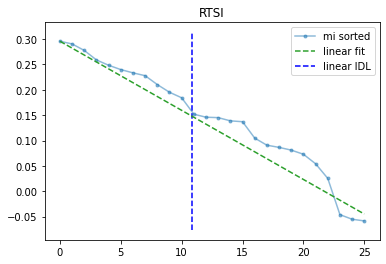

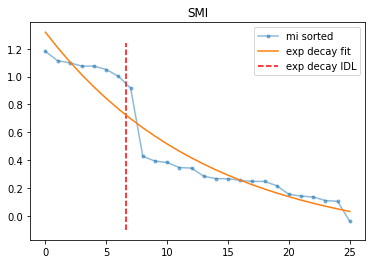

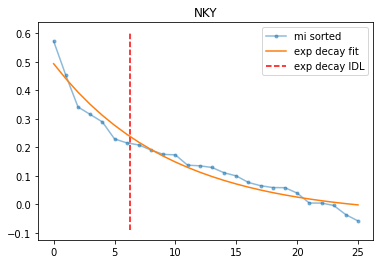

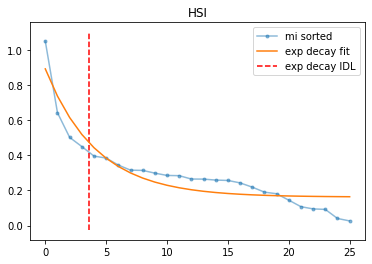

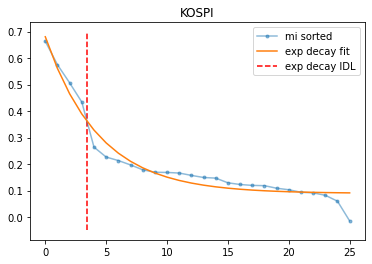

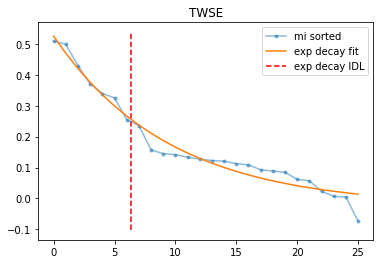

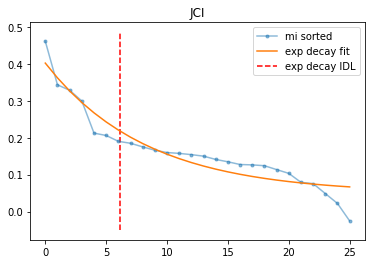

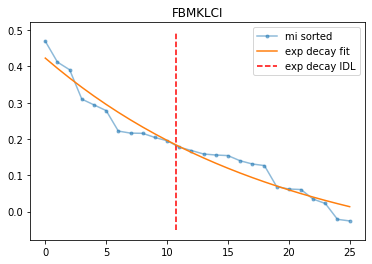

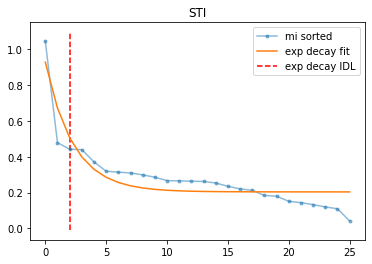

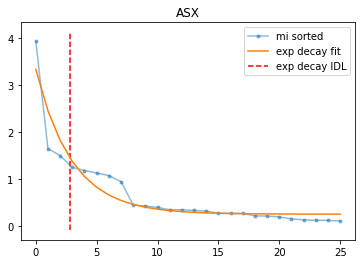

[ERROR] fitted half life was larger than total number of indices


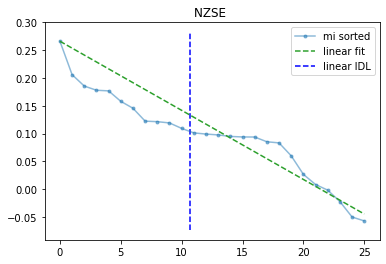

In [14]:
_ = compute_IDL(df["2008-05":"2009-05"])

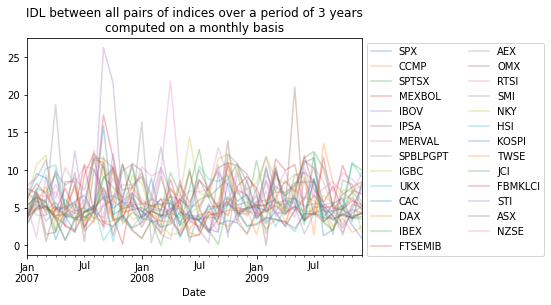

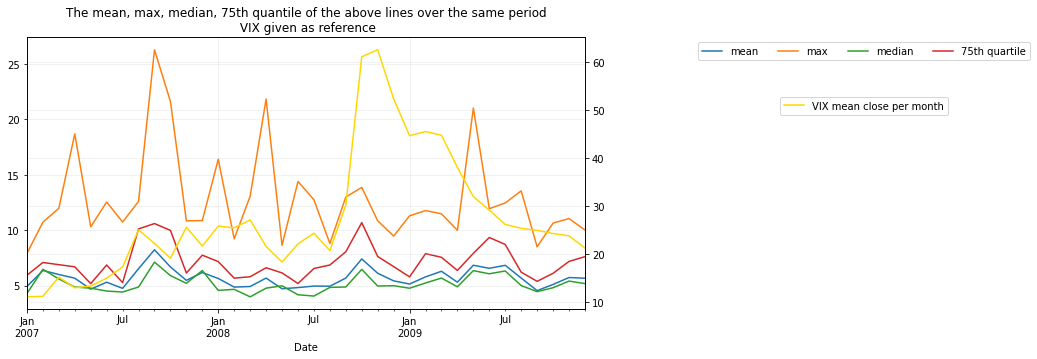

In [15]:
out = df["2007":"2009"].groupby(pd.Grouper(freq="M")).apply(
    lambda x: compute_IDL(x, plot=False)
)
out.plot(alpha=0.3)
plt.title("IDL between all pairs of indices over a period of 3 years\ncomputed on a monthly basis")
plt.legend(bbox_to_anchor=(1,1), ncol=2)
plt.show()

plt.figure(figsize=(10,5))
plt.title("The mean, max, median, 75th quantile of the above lines over the same period\n VIX given as reference")
out.mean(axis=1).plot(label="mean")
out.max(axis=1).plot(label="max")
out.median(axis=1).plot(label="median")
out.quantile(q=0.75, axis=1).plot(label="75th quartile")
plt.legend(bbox_to_anchor=(1.5,1), ncol=4, loc=9)
plt.grid(alpha=0.2)
plt.twinx()
VIX["2007":"2009"].groupby(pd.Grouper(freq="M")).mean().plot(color="gold", label="VIX mean close per month")
plt.legend(bbox_to_anchor=(1.5,0.8), ncol=2, loc=9)
plt.grid(alpha=0.2)
plt.show()

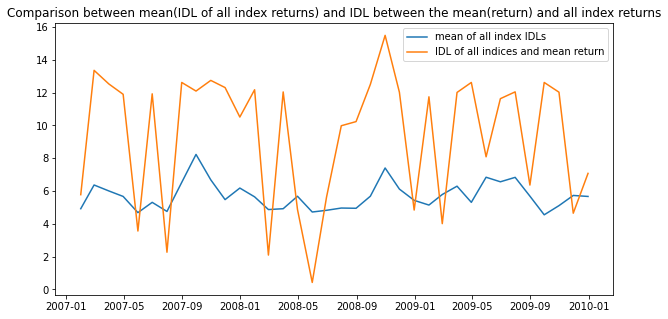

In [16]:
plt.figure(figsize=(10,5))
out2 = df["2007":"2009"].groupby(pd.Grouper(freq="M")).apply(
    lambda x: compute_IDL2(x, using="mean", plot=False)
)
plt.title("Comparison between mean(IDL of all index returns) and IDL between the mean(return) and all index returns")
plt.plot(out.mean(axis=1), label="mean of all index IDLs")
plt.plot(out2, label="IDL of all indices and mean return", color="C1")
plt.legend()
plt.show()

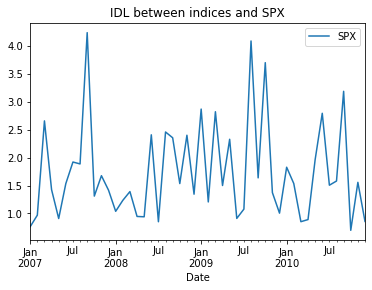

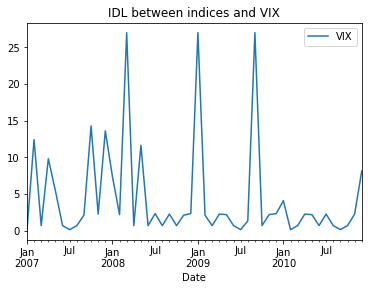

In [17]:
out = df["2007":"2010"].groupby(pd.Grouper(freq="M")).apply(
    lambda x: compute_IDL2(x, using="SPX", plot=False)
)
out.plot()
plt.title("IDL between indices and SPX")
plt.show()

out = df["2007":"2010"].groupby(pd.Grouper(freq="M")).apply(
    lambda x: compute_IDL2(x, using="VIX", plot=False)
)
out.plot()
plt.title("IDL between indices and VIX")
plt.show()

In [18]:
bigout = df["2001-07":"2019-09"].groupby(pd.Grouper(freq="M")).apply(
    lambda x: compute_IDL(x, plot=False)
)

In [19]:
SPXRVOL = df["2001-07":"2019-09"]["SPX"].groupby(pd.Grouper(freq="M")).apply(gm.compute_RVOL)

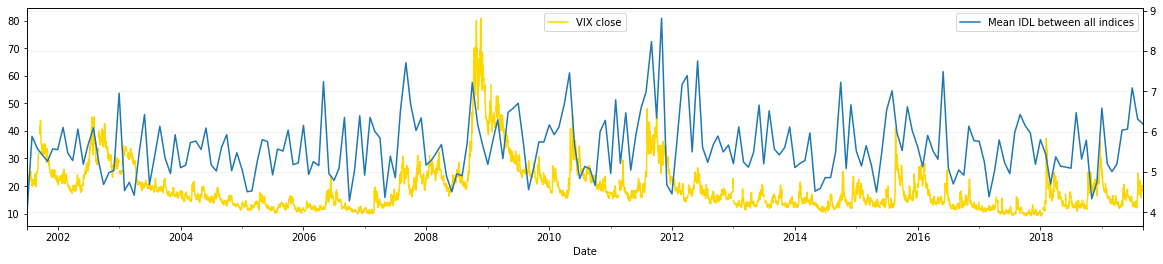

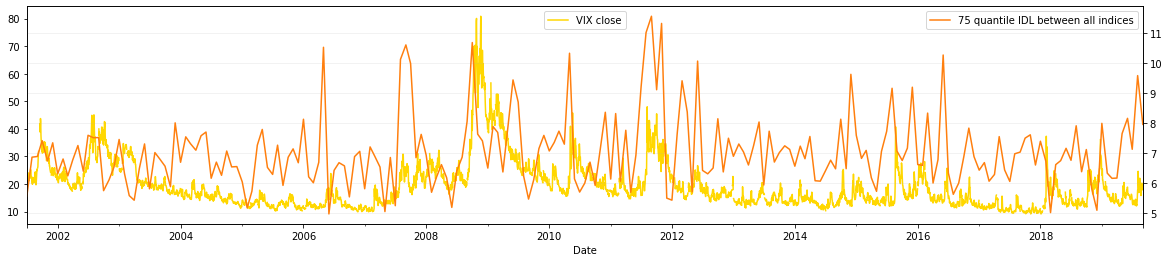

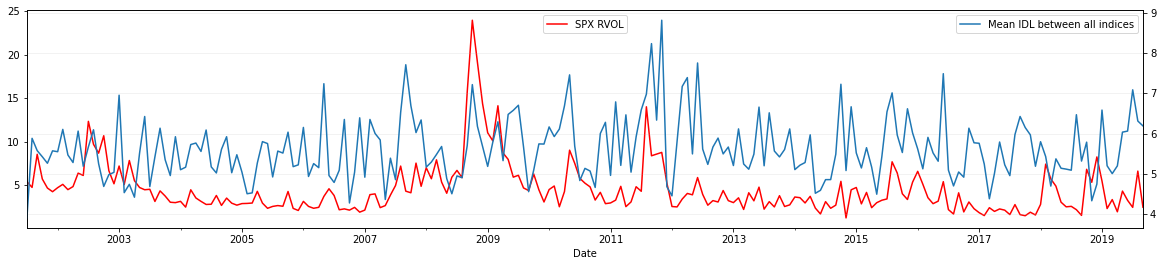

In [20]:
plt.figure(figsize=(20,4))
VIX["2001-07":"2019-09"].plot(color="gold", label="VIX close")
plt.legend(loc=9)
plt.twinx()
bigout.mean(axis=1).plot(label="Mean IDL between all indices", color="C0")
plt.legend(loc=1)
plt.grid(alpha=0.2)
plt.show()

plt.figure(figsize=(20,4))
VIX["2001-07":"2019-09"].plot(color="gold", label="VIX close")
plt.legend(loc=9)
plt.twinx()
bigout.quantile(q=0.75, axis=1).plot(label="75 quantile IDL between all indices", color="C1")
plt.legend(loc=1)
plt.grid(alpha=0.2)
plt.show()

plt.figure(figsize=(20,4))
SPXRVOL["2001-07":"2019-09"].plot(color="red", label="SPX RVOL")
plt.legend(loc=9)
plt.twinx()
bigout.mean(axis=1).plot(label="Mean IDL between all indices", color="C0")
plt.legend(loc=1)
plt.grid(alpha=0.2)
plt.show()

In [21]:
model = fit.VolatilityModel(
    path="../../data/topsecret/data251019_ret_diarios.csv",
    periodstart="2001-07",
    periodend="2019-09",
    droptickers=None#["IGBC"]#, "MERVAL"]
)

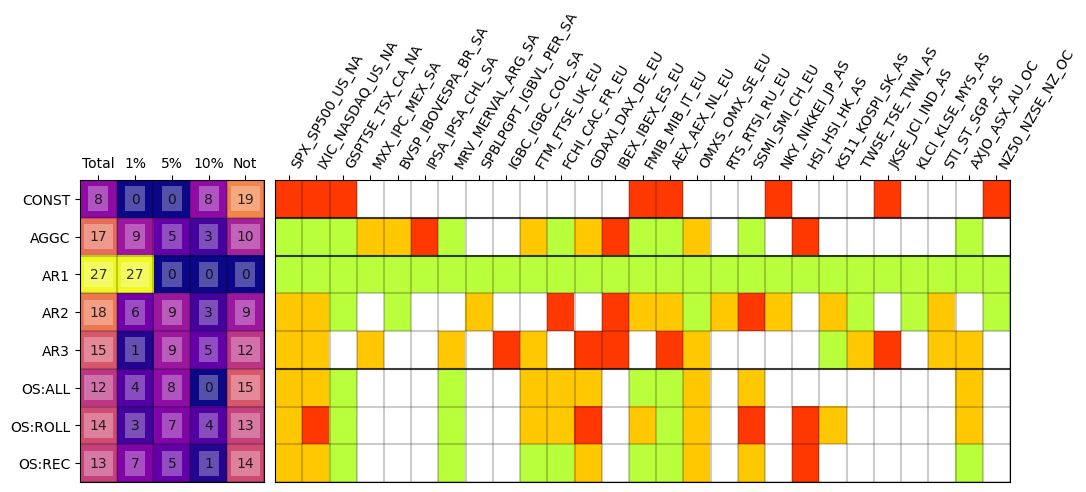

In [28]:
data_matrix, colnames, tickers, ydata = model.test(
    metricdic={
        "AGGC":(lambda x: gm.compute_AGGC(x, p=0.63), "none"),
    },
    get_ydata=True
)

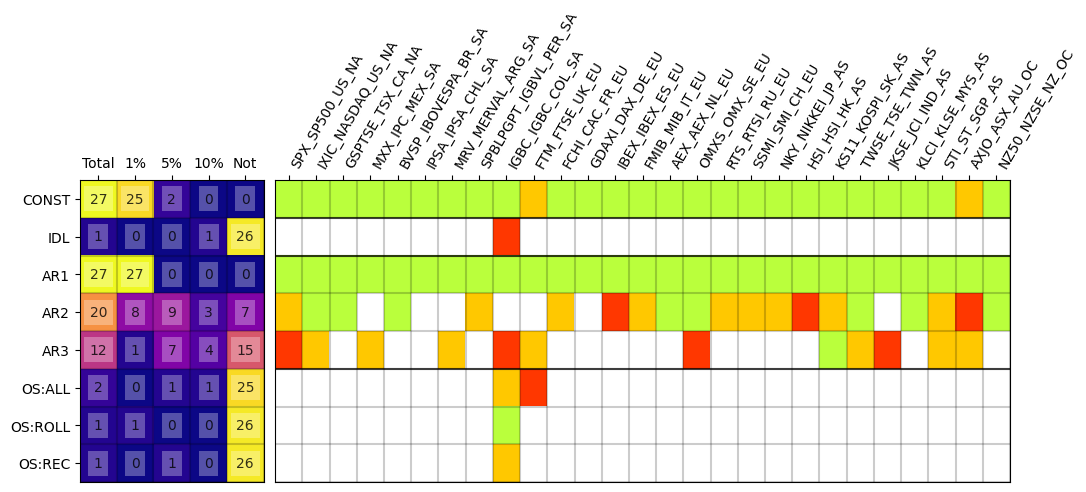

In [24]:
data_matrix, colnames, tickers, ydata = model.test(
    metricdic={
        "IDL":(bigout, "none"),
    },
    get_ydata=True
)

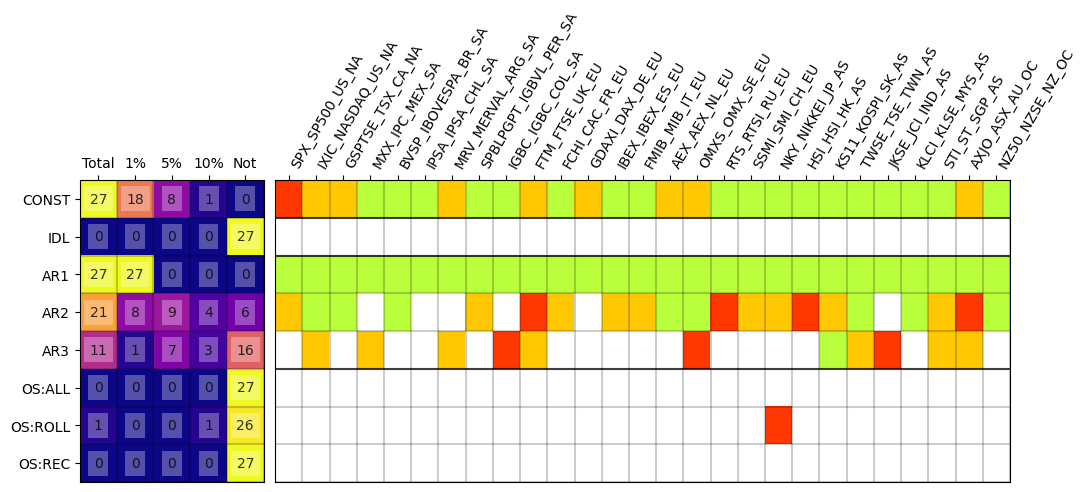

In [25]:
data_matrix, colnames, tickers, ydata = model.test(
    metricdic={
        "IDL":(bigout.mean(axis=1), "none"),
    },
    get_ydata=True
)

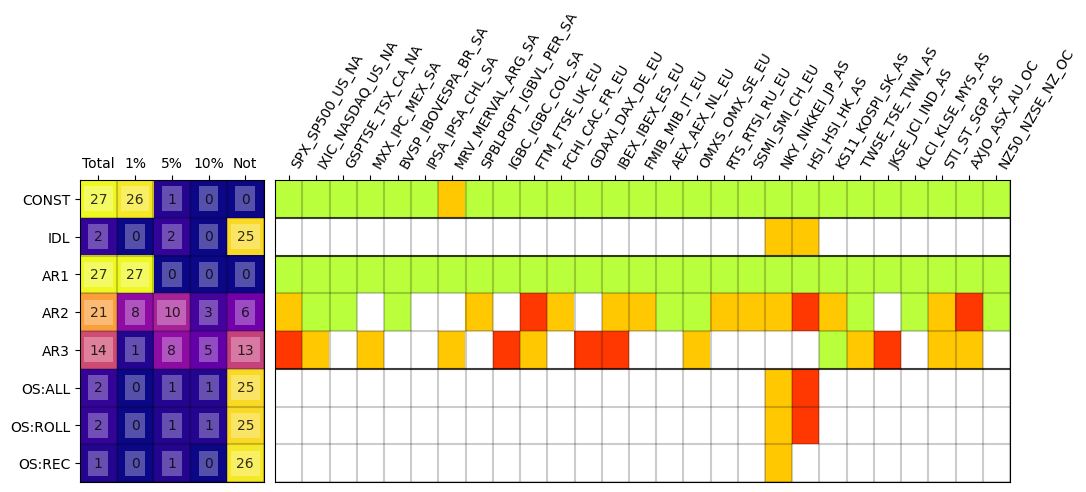

In [27]:
data_matrix, colnames, tickers, ydata = model.test(
    metricdic={
        "IDL":(bigout.quantile(q=.75, axis=1), "none"),
    },
    get_ydata=True
)